In [17]:
# Logan Herrera
# Stanford Student Space Initiative
# IREC 2017

import re

# https://www.ncdc.noaa.gov/data-access/weather-balloon/integrated-global-radiosonde-archive
# https://www1.ncdc.noaa.gov/pub/data/igra/data/data-por/
# https://www1.ncdc.noaa.gov/pub/data/igra/data/igra2-data-format.txt

any_header_pattern =    r'#USM0007236[45]\s[0-9]{4}\s[0-9]{2}\s[0-9]{2}'
target_header_pattern = r'#USM0007236[45]\s20[0-1][0-9]\s0[6-7]'    

#inputfile = 'USM00072364-ABQ-data.txt'        # Albuquerque
#outputfile = 'ABQ_IGRA_snippedoutput.txt'

inputfile = 'USM00072365-ST-data.txt'          # Santa Teresa
outputfile ='ST_IGRA_snippedoutput.txt'

any_header = re.compile(any_header_pattern)
target_header = re.compile(target_header_pattern)
f = open(inputfile,'r')
g = open(outputfile,'w')

data_block = False
for line in f:
    if not any_header.match(line) and data_block == True:
        g.write(line)    
    elif target_header.match(line):
        data_block = True
        g.write(line)        
    else:
        data_block = False
  
f.close()
g.close()
print('done!')

done!


In [1]:
import numpy as np
from scipy.interpolate import interp1d
import pprint

max_alt = 18288    # 60,000 ft MSL
min_points = 5

#inputfile = 'simplefile.txt'
#inputfile = 'ST_IGRA_snippedoutput.txt'
inputfile = 'ABQ_IGRA_snippedoutput.txt'

f = open(inputfile,'r')

key = None
data = dict()
for line in f:
    if 'USM00072364' in line or 'USM00072365' in line:
        key = line[13:26]
        key = key.replace(' ','')
        data[key] = None
    else:
        line = line.replace('A',' ')           # delete non-numeric characters (spurious A's)
        line = line.replace('B',' ')           # delete non-numeric characters (spurious B's)
        line = line.split()                    # split data on white space
        latest_datum = np.array(list(map(float, line)))    # convert list of strings to list of floats
        if latest_datum[3] <= max_alt and latest_datum[4] and latest_datum[7] != -9999 and latest_datum[8] != -9999:
            latest_datum[8] = latest_datum[8] / 10
            if data[key] is None:
                data[key] = latest_datum
            else:
                data[key] = np.vstack((data[key], latest_datum))          # append new data below previous data in key-value pair

# column 3 is GPH
# column 7 is WDIR
# column 8 is WSPD

total_rejected = 0
badkeys = []
for b in data.keys():
    if data[b] is None or data[b].ndim == 1 or len(data[b]) <= min_points:
        total_rejected += 1     
        badkeys.append(b)
        
for c in badkeys:        
    del data[c]

print(total_rejected)        
        
data_interp = dict()
for a in data.keys():
    data_interp[a] = (interp1d(data[a][:,3], data[a][:,7],kind='linear',fill_value='extrapolate'), 
                      interp1d(data[a][:,3], data[a][:,8],kind='linear',fill_value='extrapolate'))
                        
f.close()
pprint.pprint('done!')


0
'done!'


In [35]:
year = np.arange(2000,2016+1,1)
day = np.arange(1,61+1,1)
alt = np.arange(1700,18100+100,100)
speed = np.empty([len(year),len(day),2,len(alt)])
heading = np.empty([len(year),len(day),2,len(alt)])
min_valid_speed = 0
max_valid_speed = 100

for i in year:
    for j in day:
        for k in [0,1]:
            inputkey = str(i) + '0' + str(6 + j//31)
            if j % 31 < 10:
                inputkey += '0'
            inputkey +=  str(j % 31)
            if k == 0:
                inputkey += '00'
            else:
                inputkey += '12'
            
            headingerrors = 0
            for h in range(0,len(alt)):
                try:
                    heading[i-2000,j-1,k,h] = data_interp[inputkey][0](1700+h*100) % 360
                except KeyError:
                    headingerrors +=1
                    heading[i-2000,j-1,k,h] = 0
            
            speederrors = 0
            for z in range(0,len(alt)):
                try:
                    speed[i-2000,j-1,k,z] = min(max(data_interp[inputkey][1](1700+z*100), min_valid_speed), max_valid_speed)
                except KeyError:
                    speederrors += 1
                    speed[i-2000,j-1,k,z] = 0
                    
print(headingerrors)
print(speederrors)
            

0
0


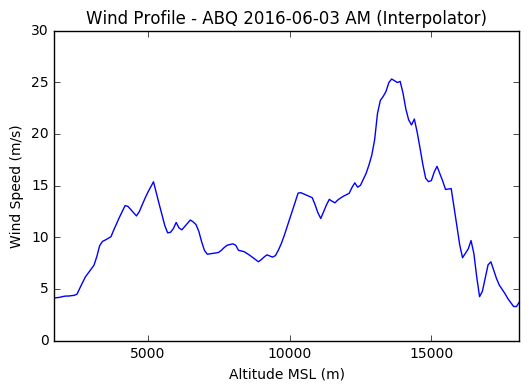

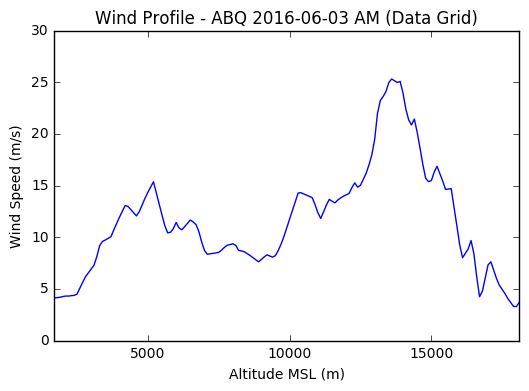

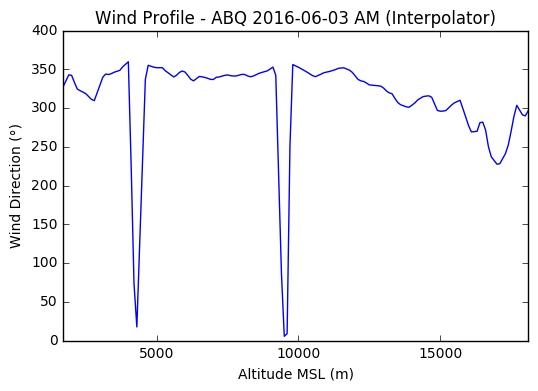

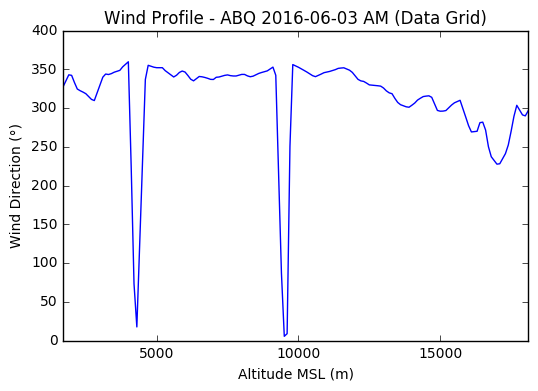

In [36]:
import matplotlib.pyplot as plt
plt.plot(alt, data_interp['2016060300'][1](alt), '-')
plt.ylabel('Wind Speed (m/s)')
plt.xlabel('Altitude MSL (m)')
plt.title('Wind Profile - ABQ 2016-06-03 AM (Interpolator)')
plt.xlim(min(alt),max(alt))
plt.show()

plt.plot(alt, speed[16][3-1][0][:], '-')
plt.ylabel('Wind Speed (m/s)')
plt.xlabel('Altitude MSL (m)')
plt.title('Wind Profile - ABQ 2016-06-03 AM (Data Grid)')
plt.xlim(min(alt),max(alt))
plt.show()

plt.plot(alt, data_interp['2016060300'][0](alt), '-')
plt.ylabel('Wind Direction (°)')
plt.xlabel('Altitude MSL (m)')
plt.title('Wind Profile - ABQ 2016-06-03 AM (Interpolator)')
plt.xlim(min(alt),max(alt))
plt.show()

plt.plot(alt, heading[16][3-1][0][:], '-')
plt.ylabel('Wind Direction (°)')
plt.xlabel('Altitude MSL (m)')
plt.title('Wind Profile - ABQ 2016-06-03 AM (Data Grid)')
plt.xlim(min(alt),max(alt))
plt.show()

In [37]:
max_index = int((33000*0.3048 - 1700)//100 + 1)
average_speed = np.mean(speed[:][:][:][0:max_index])
stddev_speed = np.std(speed[:][:][:][0:max_index])
print(average_speed)
print(stddev_speed)
average_angle = np.rad2deg(np.arctan(np.sum(np.sin(np.deg2rad(heading[:][:][:][0:max_index]))) / 
                                     np.sum(np.cos(np.deg2rad(heading[:][:][:][0:max_index])))))
print(average_angle)
# this calculated result doesn't match the graphical result below

9.7698564032
8.11151481022
84.7218677191


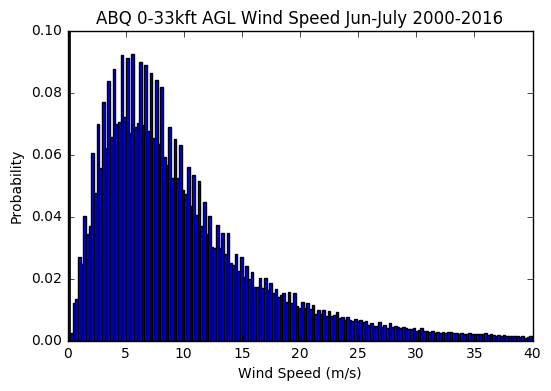

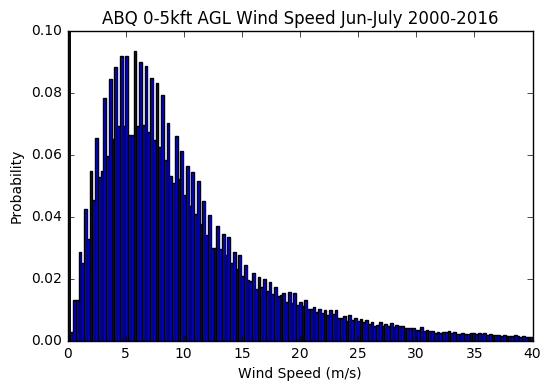

In [38]:
max_index = int((33000*0.3048 - 1700)//100 + 1)

plt.hist(np.ravel(speed[:][:][:][0:max_index]), bins='auto', normed=True, color='b')
plt.title('ABQ 0-33kft AGL Wind Speed Jun-July 2000-2016')
#plt.axvline(mode_all_velocity[0], linewidth=4, color='r')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Probability')
plt.xlim(0,40)
plt.ylim(0,0.1)
plt.show()

max_index = int((5000*0.3048 - 1700)//100 + 1)
plt.hist(np.ravel(speed[:][:][:][0:max_index]), bins='auto', normed=True)
plt.title('ABQ 0-5kft AGL Wind Speed Jun-July 2000-2016')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Probability')
plt.xlim(0,40)
plt.ylim(0,0.1)
plt.show()

#plt.hist(np.ravel(speed[:][:][:][0:max_index]), bins='auto', normed=True)
#plt.title('ABQ 0-33kft AGL Wind Speed Jun-July 2000-2016')
#plt.xlabel('Wind Speed (m/s)')
#plt.ylabel('Probability')
#plt.xlim(80,100)
#plt.ylim(0,0.01)
#plt.show()

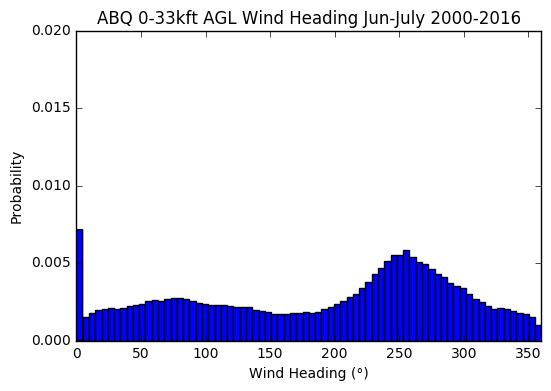

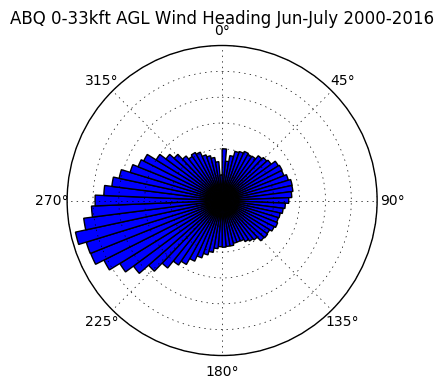

In [39]:
from scipy import stats
max_index = int((33000*0.3048 - 1700)//100 + 1)
prob, theta, _ = plt.hist(np.ravel(heading[:][:][:][0:max_index]), bins='auto', normed=True)
plt.title('ABQ 0-33kft AGL Wind Heading Jun-July 2000-2016')
plt.xlabel('Wind Heading (°)')
plt.ylabel('Probability')
plt.xlim(0,360)
plt.ylim(0,0.02)
plt.show()

theta = np.deg2rad(theta[:-1])
prob[0] = 0.002

max_height = 0.01

width = (2*np.pi) / len(theta)
ax = plt.subplot(111, polar=True)
bars = ax.bar(theta, prob, width=width)
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.axes.get_yaxis().set_ticklabels([])
ax.set_title('ABQ 0-33kft AGL Wind Heading Jun-July 2000-2016')

plt.show()

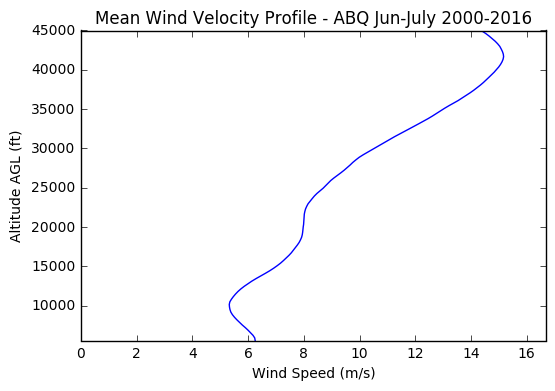

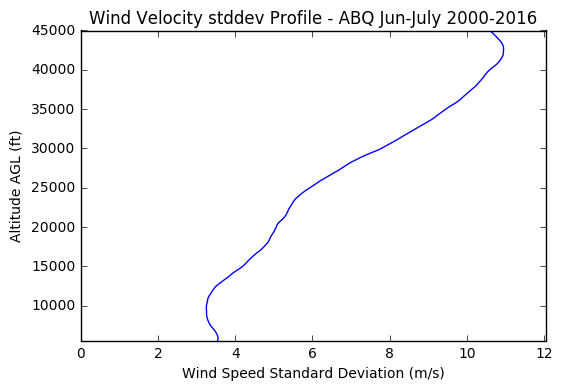

In [40]:
avg_speed_profile = speed.mean(axis=(0,1,2))
avg_speed_stddev_profile = speed.std(axis=(0,1,2))

plt.plot(avg_speed_profile, alt*3.28084, '-')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Altitude AGL (ft)')
plt.title('Mean Wind Velocity Profile - ABQ Jun-July 2000-2016')
plt.ylim(min(alt*3.28084),45000)
plt.xlim(0, 1.1*max(avg_speed_profile))
plt.show()

plt.plot(avg_speed_stddev_profile, alt*3.28084, '-')
plt.xlabel('Wind Speed Standard Deviation (m/s)')
plt.ylabel('Altitude AGL (ft)')
plt.title('Wind Velocity stddev Profile - ABQ Jun-July 2000-2016')
plt.ylim(min(alt*3.28084),45000)
plt.xlim(0, 1.1*max(avg_speed_stddev_profile))
plt.show()

In [91]:
from scipy.stats import exponweib
#wfit = stats.weibull_min.fit(np.ravel(speed[:][:][:][0:max_index]), floc=0)
wfit = exponweib.fit(np.ravel(speed[:][:][:][0:max_index]), floc=0, fa=1)
print(wfit)

(1, 1.0, 0, 1.05)


(1, 1.0, 0, 1.05)


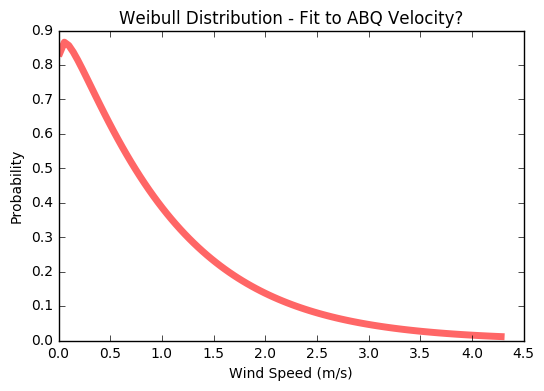

In [169]:
from scipy.stats import exponweib
print(wfit)
a = 1.0
c = 1.05
x = np.linspace(exponweib.ppf(0.01, a, c), exponweib.ppf(0.99, a, c), 100)
plt.plot(x, exponweib.pdf(x, a, c), 'r-', lw=5, alpha=0.6, label='exponweib pdf')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Probability')
plt.title('Weibull Distribution - Fit to ABQ Velocity?')
plt.show()

In [50]:
# http://stackoverflow.com/questions/25828184/fitting-to-poisson-histogram
from scipy.optimize import minimize
from scipy.misc import factorial

def poisson(x, lamb):
    """poisson pdf, parameter lamb is the fit parameter"""
    return (lamb**x/factorial(x)) * np.exp(-lamb)

def weibull(x, lamb, k):
    return (k/lamb)*(x/lamb)**(k-1)*np.exp(-(x/lamb)**k)

def exponential(x, lamb):
    return lamb*np.exp(-lamb*x)

def rayleigh(x, sigma):
    return x/sigma**2*np.exp(-x**2/(2*sigma**2))

def negLogLikelihood(params, data):
    """ the negative log-Likelihood-Function"""
    #lnl = - np.sum(np.log(poisson(data, params[0])))
    #lnl = - np.sum(np.log(exponential(data, params[0])))
    #lnl = - np.sum(np.log(rayleigh(data, params[0])))
    lnl = - np.sum(np.log(weibull(data, params[0], params[1])))
    return lnl

max_index = int((1000*0.3048 - 1700)//100 + 1)
#data = np.random.poisson(2, 1000)
data = np.ravel(speed[:][:][:][0:max_index])
              
result = minimize(negLogLikelihood,  # function to minimize
                  x0=[9, 1.6],     # start value
                  args=(data,),      # additional arguments for function
                  method='Nelder-Mead',   # minimization method, see docs
                  )
# result is a scipy optimize result object, the fit parameters 
# are stored in result.
print(result)


C:\Users\Logan\Anaconda3\lib\site-packages\ipykernel\__main__.py:23: RuntimeWarning: divide by zero encountered in log
C:\Users\Logan\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:528: RuntimeWarning: invalid value encountered in subtract
  numpy.max(numpy.abs(fsim[0] - fsim[1:])) <= fatol):


 final_simplex: (array([[ 9. ,  1.6],
       [ 9. ,  1.6],
       [ 9. ,  1.6]]), array([ inf,  inf,  inf]))
           fun: inf
       message: 'Maximum number of function evaluations has been exceeded.'
          nfev: 403
           nit: 101
        status: 1
       success: False
             x: array([ 9. ,  1.6])


In [41]:
x_plot = np.linspace(0, 40, 1000)
plt.hist(data, bins=np.arange(100) - 0.5, normed=True)
plt.xlim(0, 40)
plt.title('Mode')
plt.xlabel('Wind Speed (m/s)')
plt.show()

x_plot = np.linspace(0, 40, 1000)
plt.hist(data, bins=np.arange(100) - 0.5, normed=True)
plt.plot(x_plot, rayleigh(x_plot, 5.5), 'r-', lw=2)
plt.xlim(0, 40)
plt.title('Rayleigh distribution sigma=5.5')
plt.xlabel('Wind Speed (m/s)')
plt.show()

x_plot = np.linspace(0, 40, 1000)
plt.hist(data, bins=np.arange(100) - 0.5, normed=True)
plt.plot(x_plot, exponential(x_plot, 0.1), 'r-', lw=2)
plt.xlim(0, 40)
plt.title('Exponential distribution lambda=0.1')
plt.xlabel('Wind Speed (m/s)')
plt.show()


TypeError: cannot perform reduce with flexible type

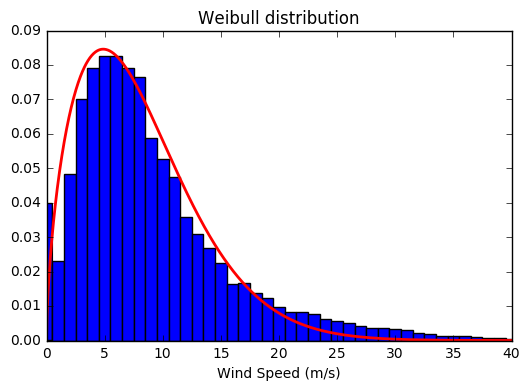

In [52]:
x_plot = np.linspace(0, 40, 1000)
plt.hist(data, bins=np.arange(100) - 0.5, normed=True)
plt.plot(x_plot, weibull(x_plot, 9, 1.6), 'r-', lw=2)
plt.xlim(0, 40)
plt.title('Weibull distribution')
plt.xlabel('Wind Speed (m/s)')
plt.show()

C:\Users\Logan\Anaconda3\lib\site-packages\ipykernel\__main__.py:10: RuntimeWarning: overflow encountered in power
C:\Users\Logan\Anaconda3\lib\site-packages\ipykernel\__main__.py:10: RuntimeWarning: invalid value encountered in multiply
C:\Users\Logan\Anaconda3\lib\site-packages\ipykernel\__main__.py:10: RuntimeWarning: overflow encountered in multiply


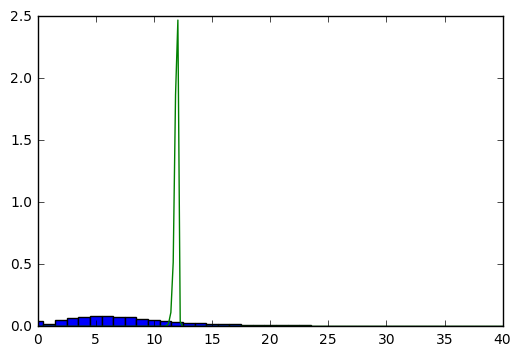

In [61]:
import scipy.optimize
import numpy as np

x, y = np.histogram(data, bins=20)
y = y[:-1]
params, _ = scipy.optimize.curve_fit(weibull, x, y)
X = np.linspace(0, 40, 200)
plt.hist(data, bins=np.arange(100) - 0.5, normed=True)
plt.plot(X, weibull(X, *params))
plt.xlim(0, 40)
plt.show()

(1.0, 0, 1.05)


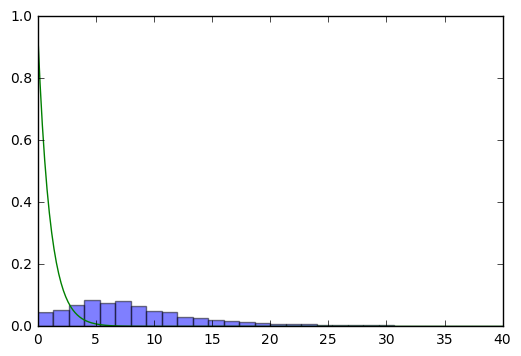

In [63]:
def weibull(x, lamb, k):
        return (k/lamb)*(x/lamb)**(k-1)*np.exp(-(x/lamb)**k)

from scipy import stats
data = np.array(list(filter(lambda x: x<40, list(data))))
p = stats.weibull_min.fit(data, floc=0)
X = np.linspace(0, 40, 200)
plt.hist(data,bins=30,alpha=0.5,normed=True)
print(p)
plt.plot(X, scipy.stats.weibull_min.pdf(X, *p))
plt.xlim(0,40)
plt.show()